In [1]:
pip install tensorflow numpy scikit-learn biopython

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# Import necessary libraries
import numpy as np
from Bio import SeqIO
from sklearn.model_selection import train_test_split
import gc # Garbage Collector interface
import random # To shuffle the data before subsampling

In [14]:
# --- 1. Define Constants & Functions ---

SEQ_LENGTH = 2000
# Using np.int8 is 8x more memory-efficient than the default float64
DNA_MAP = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}

def one_hot_encode(sequence, dtype=np.int8):
    """Converts a DNA sequence string into a one-hot encoded NumPy array."""
    one_hot = np.zeros((len(sequence), 4), dtype=dtype)
    for i, base in enumerate(sequence):
        one_hot[i, :] = DNA_MAP.get(base.upper(), DNA_MAP['N'])
    return one_hot

def process_fasta_file(filepath):
    """Reads a FASTA file and returns a list of sequence strings."""
    sequences = []
    for record in SeqIO.parse(filepath, "fasta"):
        sequences.append(str(record.seq))
    return sequences


In [15]:
# --- 2. Load and Process Promoter (Positive) Sequences ---

print("Loading promoter sequences...")
promoter_seqs = process_fasta_file('promoters.fasta')
promoter_seqs = [seq for seq in promoter_seqs if len(seq) == SEQ_LENGTH]
print(f"Found {len(promoter_seqs)} total promoter sequences.")


Loading promoter sequences...
Found 403891 total promoter sequences.


In [16]:
# --- 3. Load and Process Non-Promoter (Negative) Sequences ---

print("\nLoading and processing non-promoter sequences...")
intron_seqs_raw = process_fasta_file('non_promoters.fasta')
non_promoter_seqs = []
for intron in intron_seqs_raw:
    for i in range(0, len(intron) - SEQ_LENGTH + 1, SEQ_LENGTH):
        non_promoter_seqs.append(intron[i:i + SEQ_LENGTH])
del intron_seqs_raw
gc.collect()
print(f"Generated {len(non_promoter_seqs)} total non-promoter sequences.")



Loading and processing non-promoter sequences...
Generated 6628575 total non-promoter sequences.


In [17]:
# --- 4. NEW: Subsample the Data to Fit in Memory ---

print("\nSubsampling data to create a smaller dataset for local training...")
MAX_SAMPLES_PER_CLASS = 50000 # You can adjust this number based on your RAM

# Shuffle the lists to get a random sample
random.shuffle(promoter_seqs)
random.shuffle(non_promoter_seqs)

# Take a slice of each list
promoter_seqs_sample = promoter_seqs[:MAX_SAMPLES_PER_CLASS]
non_promoter_seqs_sample = non_promoter_seqs[:MAX_SAMPLES_PER_CLASS]

# Clear original large lists to free up memory
del promoter_seqs
del non_promoter_seqs
gc.collect()

print(f"Using {len(promoter_seqs_sample)} promoter and {len(non_promoter_seqs_sample)} non-promoter samples.")


Subsampling data to create a smaller dataset for local training...
Using 50000 promoter and 50000 non-promoter samples.


In [18]:
# --- 5. Memory-Efficient Data Population ---

print("\nPre-allocating arrays for the smaller dataset...")

# Calculate total number of samples
num_samples = len(promoter_seqs_sample) + len(non_promoter_seqs_sample)

# Pre-allocate the final arrays
X = np.zeros((num_samples, SEQ_LENGTH, 4), dtype=np.int8)
y = np.zeros(num_samples, dtype=np.int8)

# Populate the arrays
print("Processing sampled promoters...")
for i, seq in enumerate(promoter_seqs_sample):
    X[i] = one_hot_encode(seq)
    y[i] = 1

print("Processing sampled non-promoters...")
offset = len(promoter_seqs_sample)
for i, seq in enumerate(non_promoter_seqs_sample):
    X[offset + i] = one_hot_encode(seq)
    y[offset + i] = 0

del promoter_seqs_sample
del non_promoter_seqs_sample
gc.collect()

print(f"Final shape of X: {X.shape}")
print(f"Final shape of y: {y.shape}")


Pre-allocating arrays for the smaller dataset...
Processing sampled promoters...
Processing sampled non-promoters...
Final shape of X: (100000, 2000, 4)
Final shape of y: (100000,)


In [19]:
# --- 6. Shuffle and Split into Training and Testing Sets ---

print("\nSplitting into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print("\nPreprocessing complete. You are ready to build and train the model.")


Splitting into training and testing sets...
Shape of X_train: (80000, 2000, 4)
Shape of X_test: (20000, 2000, 4)

Preprocessing complete. You are ready to build and train the model.


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# --- 1. Define the Model Architecture ---

print("Building the CNN model...")
model = Sequential([
    # Input Layer: A 1D Convolutional layer to find motifs
    # input_shape should be (sequence_length, num_channels)
    Conv1D(filters=32, kernel_size=12, activation='relu', input_shape=(2000, 4)),
    
    # Pooling layer to reduce dimensionality and highlight important features
    MaxPooling1D(pool_size=4),
    
    # Flatten the 2D output of the conv/pool layers to a 1D vector
    Flatten(),
    
    # A standard fully-connected layer for classification
    Dense(64, activation='relu'),
    
    # Dropout layer to prevent overfitting
    Dropout(0.5),
    
    # Output Layer: A single neuron with a sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# Print a summary of the model's architecture
model.summary()

Building the CNN model...


c:\Users\siddh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1989, 32)       │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 497, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,017,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,019,553 (3.89 MB)

 Trainable params: 1,019,553 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# --- 2. Compile the Model ---

print("\nCompiling the model...")
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- 3. Train the Model ---

print("\nTraining the model...")
# We will store the training history to plot it later
history = model.fit(
    X_train,
    y_train,
    epochs=10, # Start with 10 epochs
    batch_size=32, # Process data in batches of 32
    validation_data=(X_test, y_test) # Evaluate on test data after each epoch
)

# --- 4. Evaluate Final Performance ---

print("\nEvaluating final model performance on the test set...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


Compiling the model...

Training the model...
Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - accuracy: 0.6839 - loss: 0.6057 - val_accuracy: 0.7494 - val_loss: 0.5104
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 56s 22ms/step - accuracy: 0.7612 - loss: 0.5010 - val_accuracy: 0.7501 - val_loss: 0.5105
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 65s 26ms/step - accuracy: 0.7816 - loss: 0.4629 - val_accuracy: 0.7520 - val_loss: 0.5188
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 63s 25ms/step - accuracy: 0.8124 - loss: 0.4139 - val_accuracy: 0.7491 - val_loss: 0.5306
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - accuracy: 0.8338 - loss: 0.3723 - val_accuracy: 0.7427 - val_loss: 0.5683
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.8612 - loss: 0.3226 - val_accuracy: 0.7343 - val_loss: 0.6165
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 62s 25ms/step - accuracy: 0.8810 - loss: 0.2792 - val_accuracy: 0.7352 - val_loss: 0.6693
Epoch 8/10
2500/2500 ━━━━━━━━

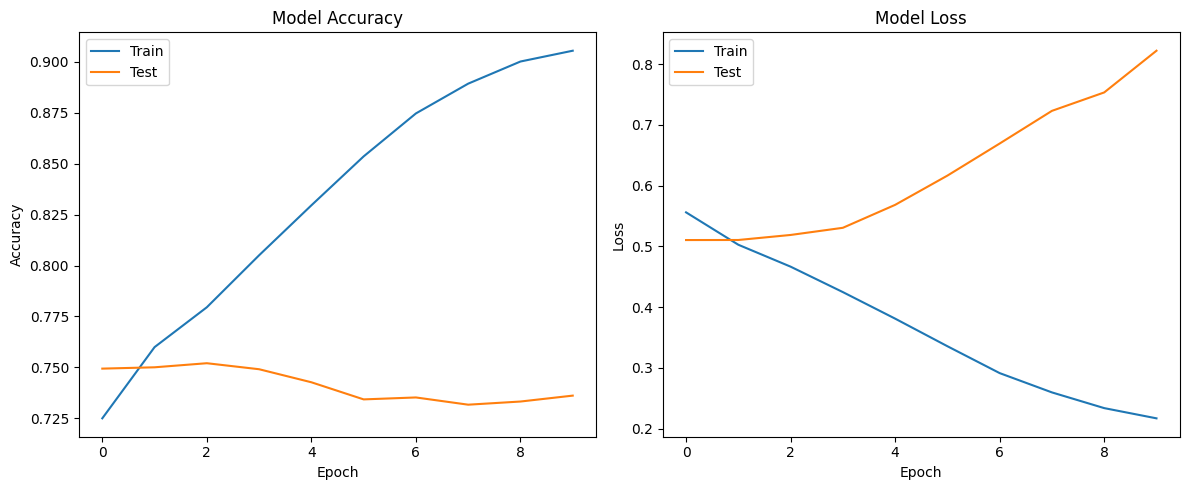

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32") # Convert probabilities to 0 or 1

# Print Classification Report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Promoter', 'Promoter']))

# Print Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Classification Report:
              precision    recall  f1-score   support

Non-Promoter       0.71      0.79      0.75     10000
    Promoter       0.76      0.68      0.72     10000

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000


Confusion Matrix:
[[7898 2102]
 [3175 6825]]


In [24]:
# Save the entire model to a single file
model.save('promoter_classifier_model.h5')

print("\nModel saved successfully as promoter_classifier_model.h5")


Model saved successfully as promoter_classifier_model.h5
